# Attribute Inference

Implememntation of Attribute Inference Attack according to Song, C., & Shmatikov, V. (2019). Overlearning reveals sensitive attributes. arXiv preprint arXiv:1905.11742.

Some parts based on https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py and https://gist.github.com/erykml/cf4e23cf3ab8897b287754dcb11e2f84#file-lenet_network-py

In [1]:
import pandas as pd
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
import copy
import PIL

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Split dataset (as described in the paper)

In [3]:
RANDOM_SEED = 42
PATH = 'UTKFace/'
TEST_SPLIT = 0.2
ATTACK_SPLIT = 0.5 # 50% of training data

samples=pd.DataFrame(columns=['filename','gender','race'])
samples['filename'] = pd.Series([file for file in glob.glob(PATH + '*') 
                                 if len(file) == len(PATH) + len('61_1_0_20170104183517277.jpg.chip.jpg')])

samples['gender'] = samples['filename'].apply(lambda x: (x.split("_")[1]))
samples['race'] = samples['filename'].apply(lambda x: (x.split("_")[2]))

np.random.seed(RANDOM_SEED)

dataset_size = len(samples)
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

attack_indices = copy.deepcopy(train_indices)
attack_split = int(np.floor(ATTACK_SPLIT * len(train_indices)))
np.random.shuffle(attack_indices)
attack_indices = attack_indices[attack_split:]

train_samples = samples.iloc[train_indices]
test_samples = samples.iloc[test_indices]
attack_samples = samples.iloc[attack_indices]

## Costum Dataset Class

In [4]:
class UTKFace(Dataset):
    """UTK Face dataset."""

    def __init__(self, samples, label, transform=None):
        """
            samples (df): df containing the path and labels of each sample (columns=['filename','gender','race'])
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.samples = samples
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.samples.iloc[idx, 0]
        image = PIL.Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        if self.label =='gender':
            label = int(self.samples.iloc[idx, 1])
            sample =  {'image': image, 'gender': label}
            
        if self.label == 'race':
            label = int(self.samples.iloc[idx, 2])
            sample =  {'image': image, 'race': label}
        
        return sample

## Load Data and Display some samples

In [5]:
transform = transforms.Compose([
        transforms.Resize([50, 50]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
dataset = UTKFace(samples=train_samples, label='gender',transform=transform)

'Number of Samples: 16485'

'Image Dim: torch.Size([3, 50, 50])'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


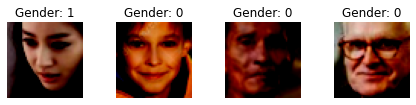

In [7]:
display('Number of Samples: ' + str(len(dataset)))
display('Image Dim: ' + str(dataset[0]['image'].shape))

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Gender: ' + str(sample['gender']))
    ax.axis('off')
    plt.imshow(sample['image'].permute(1, 2, 0).numpy())

    if i == 3:
        plt.show()
        break


# Target Model

## CNN as described in the paper

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1024, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh()
        )
        
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        y = self.output(x)
        return y, x

## Training (parameters as described in the paper)

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 30

In [10]:
net = LeNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [11]:
trainloader = torch.utils.data.DataLoader(UTKFace(train_samples, 'gender', transform), 
                                            batch_size=BATCH_SIZE)

testloader = torch.utils.data.DataLoader(UTKFace(test_samples, 'gender', transform), 
                                            batch_size=BATCH_SIZE)

In [12]:
for epoch in range(EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.values()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.456
[2,   100] loss: 0.311
[3,   100] loss: 0.280
[4,   100] loss: 0.267
[5,   100] loss: 0.259
[6,   100] loss: 0.252
[7,   100] loss: 0.244
[8,   100] loss: 0.236
[9,   100] loss: 0.228
[10,   100] loss: 0.220
[11,   100] loss: 0.213
[12,   100] loss: 0.208
[13,   100] loss: 0.203
[14,   100] loss: 0.197
[15,   100] loss: 0.191
[16,   100] loss: 0.184
[17,   100] loss: 0.178
[18,   100] loss: 0.171
[19,   100] loss: 0.163
[20,   100] loss: 0.155
[21,   100] loss: 0.147
[22,   100] loss: 0.140
[23,   100] loss: 0.131
[24,   100] loss: 0.123
[25,   100] loss: 0.114
[26,   100] loss: 0.106
[27,   100] loss: 0.097
[28,   100] loss: 0.088
[29,   100] loss: 0.084
[30,   100] loss: 0.083
Finished Training


In [13]:
PATH = './target_model_' + str(EPOCHS) + '.pth'
torch.save(net.state_dict(), PATH)

## Testing

In [14]:
net = LeNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data.values()
        # calculate outputs by running images through the network
        outputs, _ = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 90 %


In [16]:
classes = ['0', '1']

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data.values()
        outputs, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class 0     is: 96.0 %
Accuracy for class 1     is: 84.5 %


# ATTACK

## Attack Dataset Class

In [17]:
class AttackData(Dataset):
    """UTK Face dataset."""

    def __init__(self, samples, target_model, transform=None):
        """
        Args:
            samples (df): df containing the path and labels of each sample (columns=['filename','gender','race'])
            taget_model (nn.Module): model that should be queryed to get the posteriors
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        
        self.samples = samples
        self.target_model = target_model
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.samples.iloc[idx, 0]
        image = PIL.Image.open(img_name)
        if self.transform:
            image = self.transform(image)
                
        _, z = self.target_model(image.unsqueeze(0))
        
        label = int(self.samples.iloc[idx, 2])
        sample =  {'z': z, 'race': label}
        
        return sample

## Attack model as described in Paper???

In [18]:
class AttackNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Training

In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 50

In [20]:
attack_net = AttackNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attack_net.parameters(), lr=LEARNING_RATE)

In [21]:
attack_data = AttackData(attack_samples, net, transform)
attackloader = torch.utils.data.DataLoader(attack_data, 
                                            batch_size=BATCH_SIZE)

In [22]:
for epoch in range(EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(attackloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data.values()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = attack_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 1.499
[1,    40] loss: 1.378
[1,    60] loss: 1.303
[2,    20] loss: 1.282
[2,    40] loss: 1.247
[2,    60] loss: 1.217
[3,    20] loss: 1.229
[3,    40] loss: 1.204
[3,    60] loss: 1.180
[4,    20] loss: 1.196
[4,    40] loss: 1.178
[4,    60] loss: 1.157
[5,    20] loss: 1.173
[5,    40] loss: 1.160
[5,    60] loss: 1.141
[6,    20] loss: 1.156
[6,    40] loss: 1.147
[6,    60] loss: 1.129
[7,    20] loss: 1.143
[7,    40] loss: 1.135
[7,    60] loss: 1.118
[8,    20] loss: 1.132
[8,    40] loss: 1.125
[8,    60] loss: 1.108
[9,    20] loss: 1.122
[9,    40] loss: 1.116
[9,    60] loss: 1.100
[10,    20] loss: 1.113
[10,    40] loss: 1.107
[10,    60] loss: 1.092
[11,    20] loss: 1.104
[11,    40] loss: 1.100
[11,    60] loss: 1.085
[12,    20] loss: 1.096
[12,    40] loss: 1.092
[12,    60] loss: 1.078
[13,    20] loss: 1.089
[13,    40] loss: 1.086
[13,    60] loss: 1.071
[14,    20] loss: 1.083
[14,    40] loss: 1.079
[14,    60] loss: 1.065
[15,    20] loss: 1

In [23]:
PATH = './attack_model_' + str(EPOCHS) + '.pth'
torch.save(attack_net.state_dict(), PATH)

## Testing

In [24]:
attack_net = AttackNet()
attack_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
attack_test_loader = torch.utils.data.DataLoader(AttackData(train_samples, net, transform), 
                                            batch_size=BATCH_SIZE)

In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in attack_test_loader:
        images, labels = data.values()
        # calculate outputs by running images through the network
        outputs = attack_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct)
print(total)
print('Accuracy: %d %%' % (
    100 * correct / total))

10214
16485
Accuracy: 61 %


In [27]:
classes = ['0', '1', '2', '3', '4']

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in attack_test_loader:
        images, labels = data.values()
        outputs = attack_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
display('total predictions:')           
display(total_pred)
display('correct predictions:')           
display(correct_pred)
            
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname] + 0.000001)
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

'total predictions:'

{'0': 7185, '1': 3474, '2': 2009, '3': 2775, '4': 1042}

'correct predictions:'

{'0': 5535, '1': 2609, '2': 720, '3': 1262, '4': 88}

Accuracy for class 0     is: 77.0 %
Accuracy for class 1     is: 75.1 %
Accuracy for class 2     is: 35.8 %
Accuracy for class 3     is: 45.5 %
Accuracy for class 4     is: 8.4 %
